# <img src = "./resources/GA.png" width = "25" height = "25" /> <span style = "color:Purple" > Project 5 : Food Insecurity Regression Study </span> 
---
## <span style = "color:Green" > Preprocessing / Modeling </span>      

#### Ira Seidman, Alec Edgecliffe-Johnson, Ryan McDonald, Andrew Roberts - General Assembly 
---

In this notebook we develop three univariate time series models using Arima, Auto Arima and Prophet to forecast predictions for food insecurity rates by state until 2026. We then develop a method to generate these predictions for each state in the country, save the predictions to a dataframe and then concatenate all dataframes together into a single dataframe. Ultimately, given the poor accuracy of the Arima and Auto-Arima models, we do not keep these models and instead use the predictions from the Prophet model as our forecasted food insecurity rates. We use this exported dataframe with our forecasts in Tableau, which is then hosted on our Streamlit app, the script for which can be found in the **'04_streamlit_code.py'** file in the usa-food-insecurity-heroku-local-repo folder.

### Notebook Contents:

- [Reading the Data](#intro)
- [Model Preprocessing](#pre)
- [Time Series Models](#model)
    - [ARIMA](#ARIMA)
    - [Auto-ARIMA](#auto)
    - [Prophet](#prophet)
    - [Aggregation 1 (ARIMA+Auto-ARIMA)](#agg1)
    - [Aggregation 2 (ARIMA+Auto-ARIMA+Prophet)](#agg2)
- [Merging Forecast w/ Original Data](#merge)

**Imports**

In [1]:
# Data manipulation imports
import pandas as pd
import numpy as np

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from sklearn.metrics import r2_score, mean_squared_error
import datetime
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

<a id='intro'></a>
## 1. Reading in the Datasets to clean

In [2]:
df = pd.read_csv('./data/time_series/df_ts_state_mean_years.csv')

In [3]:
#Dropping unnecessary columns, transposing and resetting index
df = df.drop(columns = 'fips', axis = 1)
df = df.rename(columns = {"state_name": ""})
df_t = df.T
df_t.reset_index()

,index,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,50
0,,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1,2009,20.3791,15.0217,20.7467,19.2573,17.9897,14.1266,11.7125,12.3667,15.8,...,12.2385,18.9253,17.9217,15.9448,13.7786,14.0519,16.0667,15.0255,13.35,11.9174
2,2010,19.2925,14.5739,19.5533,18.9813,17.8,14.2578,12.05,12,16.4595,...,12.0969,16.7547,17.4213,16.2759,12.8643,13.4256,15.6795,15.5127,12.4847,12.1348
3,2011,19.4974,14.6945,19.0905,19.7142,17.4267,15.5429,14.532,13.2307,15.7153,...,12.5206,17.6031,18.7452,16.7488,13.0501,12.681,16.1271,15.2692,13.0329,11.9896
4,2012,18.5696,13.9695,17.8472,19.4305,16.2444,14.5681,13.8833,13.0303,14.4768,...,12.3429,17.0657,18.3192,15.5441,13.3592,12.1371,14.9552,14.9983,12.6497,13.0046
5,2013,18.8006,14.2491,17.5261,19.743,14.9527,13.9147,13.5801,13.212,14.9958,...,12.442,17.0539,17.594,14.5963,13.5662,11.8959,14.6011,15.7741,12.4331,12.7811
6,2014,18.9522,15.9304,17.64,19.7547,14.6621,12.8109,11.975,11.9,13.5,...,12.5631,15.5495,15.663,14.4793,12.8143,12.9346,14.159,15.2273,11.4139,12.4304
7,2015,18.4925,15.3478,16.96,19.144,13.7672,11.8625,11.25,11.6333,12.7,...,12.3477,14.8989,15.0339,14.2897,12.25,12.488,13.3154,14.8982,10.8653,12.0348
8,2016,18.0925,14.8652,16.16,18.1387,13.0655,11.0625,10.725,11.4667,11.9,...,11.7554,14.0937,14.8614,13.9586,11.6857,12.0346,13.0615,14,10.2333,12.4348
9,2017,17.1552,14.7783,15.5333,17.7587,12.3897,10.5609,10.475,11.4667,11.4,...,12.0046,13.3274,14.4701,13.4138,11.5,11.7429,12.4231,13.8036,9.6125,11.787


In [4]:
# #Exporting to CSV
df_t.to_csv('./data/time_series/df_ts_rev.csv')

In [5]:
#Reimporting a renamed file
df_rev = pd.read_csv('./data/time_series/df_ts_rev_fin_yr10.csv')
df_rev.head()

,Unnamed: 0,time,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0,2010-01-01,20.379104,15.021739,20.746667,19.257333,17.989655,14.126563,11.712500,12.366667,...,12.238462,18.925263,17.921654,15.944828,13.778571,14.051880,16.066667,15.025455,13.350000,11.917391
1,1,2011-01-01,19.292537,14.573913,19.553333,18.981333,17.800000,14.257813,12.050000,12.000000,...,12.096923,16.754737,17.421260,16.275862,12.864286,13.425564,15.679487,15.512727,12.484722,12.134783
2,2,2012-01-01,19.497412,14.694528,19.090460,19.714232,17.426683,15.542930,14.532038,13.230666,...,12.520599,17.603121,18.745160,16.748769,13.050120,12.680996,16.127143,15.269241,13.032920,11.989623
3,3,2013-01-01,18.569592,13.969532,17.847161,19.430470,16.244368,14.568059,13.883338,13.030318,...,12.342894,17.065653,18.319248,15.544147,13.359190,12.137138,14.955172,14.998278,12.649662,13.004587
4,4,2014-01-01,18.800626,14.249142,17.526119,19.743033,14.952682,13.914748,13.580065,13.212005,...,12.442048,17.053937,17.593981,14.596301,13.566219,11.895906,14.601072,15.774113,12.433148,12.781083


In [6]:
# Final drop
df_rev = df_rev.drop(columns = 'Unnamed: 0', axis = 1)
df_rev['time'] = pd.to_datetime(df_rev['time'], format = "%Y/%m/%d")

<a id='pre'></a>
## 2. Modeling Preprocessing - Make Train and Validation DFs

In [7]:
## Credit to https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe
df_train = pd.DataFrame(df_rev.drop(df_rev.tail(2).index))

In [8]:
df_val = pd.DataFrame(df_rev.drop(df.head(7).index))

In [9]:
df_val.head()

,time,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
7,2017-01-01,18.092537,14.865217,16.160000,18.138667,13.065517,11.062500,10.7250,11.466667,11.9,...,11.755385,14.093684,14.861417,13.958621,11.685714,12.034586,13.061538,14.000000,10.233333,12.434783
8,2018-01-01,17.155224,14.778261,15.533333,17.758667,12.389655,10.560937,10.4750,11.466667,11.4,...,12.004615,13.327368,14.470079,13.413793,11.500000,11.742857,12.423077,13.803636,9.612500,11.786957
9,2019-01-01,17.719403,14.265217,15.753333,18.238667,11.910345,11.039063,10.7625,11.366667,10.7,...,11.343077,14.424211,15.304331,12.555172,10.857143,11.111278,12.853846,14.085455,8.950000,12.256522


<a id='model'></a>
## 3. Models
<a id='ARIMA'></a>
### Model 1: ARIMA

In [10]:
## Credit to https://www.youtube.com/watch?v=axjgEgBgIY0
au = df_train[['time', 'Georgia']]
au_v = df_val[['time', 'Georgia']]

au.set_index('time', inplace = True)
au_v.set_index('time', inplace = True)

index_5_years = pd.date_range(au.index[-1], freq = 'AS-JAN', periods = 5, tz = None)

In [11]:
mod_arima = ARIMA(au, order = (1, 1, 1), freq = 'AS-JAN')
model_arima_fit = mod_arima.fit()

fcast1 = model_arima_fit.forecast(5)[0]

fcast1 = pd.Series(fcast1, index = index_5_years)
fcast1 = fcast1.rename('Arima');

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


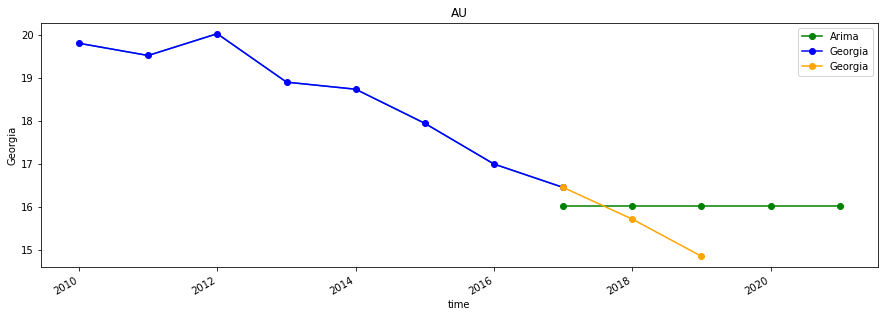

In [12]:
fig, ax = plt.subplots(figsize = (15, 5))
chart = sns.lineplot(x = 'time', y = 'Georgia', data = au)
chart.set_title('AU')
fcast1.plot(ax = ax, color = 'green', marker = 'o', legend = True)
au.plot(ax = ax, color = 'blue', marker = 'o', legend = True)
au_v.plot(ax = ax, color = 'orange', marker = 'o', legend = True);

<a id='auto'></a>
### Model 2: Auto-Arima

In [13]:
## Credit to https://www.youtube.com/watch?v=axjgEgBgIY0
auto_arima_mod = pm.auto_arima(au, seasonal = False, m = 0, error_action = 'ignore')
fcast2 = auto_arima_mod.predict(5)
fcast2 = pd.Series(fcast2, index = index_5_years)
fcast2 = fcast2.rename('Auto_Arima')

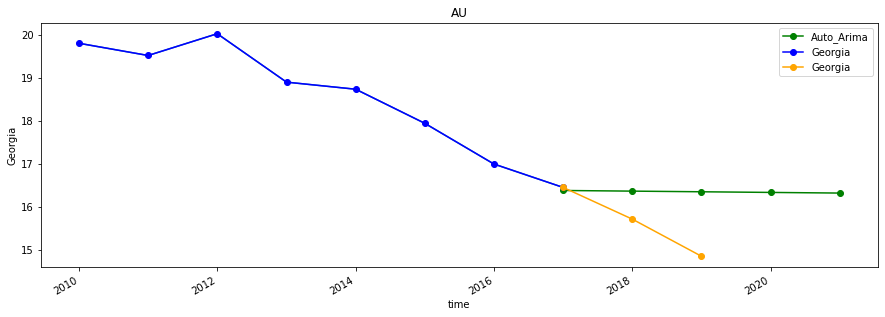

In [14]:
fig, ax = plt.subplots(figsize = (15, 5))
chart = sns.lineplot(x = 'time', y = 'Georgia', data = au)
chart.set_title('AU')
fcast2.plot(ax = ax, color = 'green', marker = 'o', legend = True)
au.plot(ax = ax, color = 'blue', marker = 'o', legend = True)
au_v.plot(ax = ax, color = 'orange', marker = 'o', legend = True);

<a id='prophet'></a>
### Model 3: Prophet

In [15]:
## Credit to https://www.youtube.com/watch?v=axjgEgBgIY0
au.head()

,Georgia
time,
2010-01-01,19.801258
2011-01-01,19.516981
2012-01-01,20.023413
2013-01-01,18.897181
2014-01-01,18.732573


In [16]:
# Copying and renaming 
au_c = df_train[['time', 'Georgia']].copy()
au_c.columns = ['ds', 'y']
au_c['ds'] = pd.to_datetime(au_c['ds'])

model_p = Prophet(n_changepoints = 5, weekly_seasonality = False, daily_seasonality = False)
model_p.fit(au_c)

future = model_p.make_future_dataframe(5, freq = 'Y')

# Make predictions
fcast3 = model_p.predict(future)

fcast3 = pd.Series(fcast3['yhat'].values, name = 'Prophet', index = fcast3['ds']);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


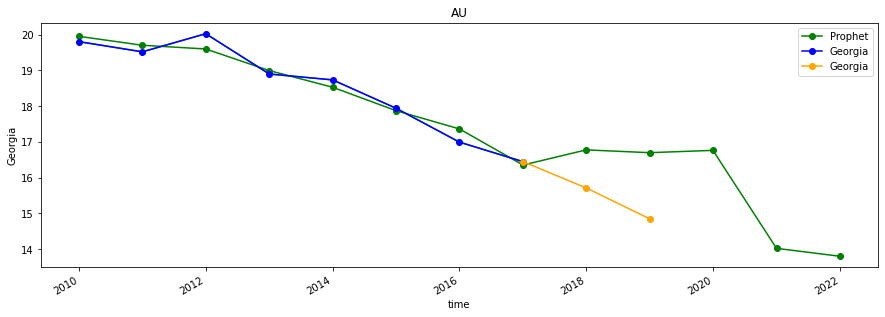

In [17]:
fig, ax = plt.subplots(figsize = (15, 5))
chart = sns.lineplot(x = 'time', y = 'Georgia', data = au)
chart.set_title('AU')
fcast3.plot(ax = ax, color = 'green', marker = 'o', legend = True)
au.plot(ax = ax, color = 'blue', marker = 'o', legend = True)
au_v.plot(ax = ax, color = 'orange', marker = 'o', legend = True);

In [18]:
# print(f'The MSE of Prophet is: {mean_squared_error(au_v['Georgia'].values, fcast3.values, squared= False)}.')

<a id='agg1'></a>
### Model Aggregation 1: Running Arima and Auto-Arima Models Side-By-Side

In [19]:
# Help and base code comes from: https://www.youtube.com/watch?v=axjgEgBgIY0
df_train.head()

,time,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2010-01-01,20.379104,15.021739,20.746667,19.257333,17.989655,14.126563,11.712500,12.366667,15.800000,...,12.238462,18.925263,17.921654,15.944828,13.778571,14.051880,16.066667,15.025455,13.350000,11.917391
1,2011-01-01,19.292537,14.573913,19.553333,18.981333,17.800000,14.257813,12.050000,12.000000,16.459510,...,12.096923,16.754737,17.421260,16.275862,12.864286,13.425564,15.679487,15.512727,12.484722,12.134783
2,2012-01-01,19.497412,14.694528,19.090460,19.714232,17.426683,15.542930,14.532038,13.230666,15.715312,...,12.520599,17.603121,18.745160,16.748769,13.050120,12.680996,16.127143,15.269241,13.032920,11.989623
3,2013-01-01,18.569592,13.969532,17.847161,19.430470,16.244368,14.568059,13.883338,13.030318,14.476778,...,12.342894,17.065653,18.319248,15.544147,13.359190,12.137138,14.955172,14.998278,12.649662,13.004587
4,2014-01-01,18.800626,14.249142,17.526119,19.743033,14.952682,13.914748,13.580065,13.212005,14.995769,...,12.442048,17.053937,17.593981,14.596301,13.566219,11.895906,14.601072,15.774113,12.433148,12.781083


/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


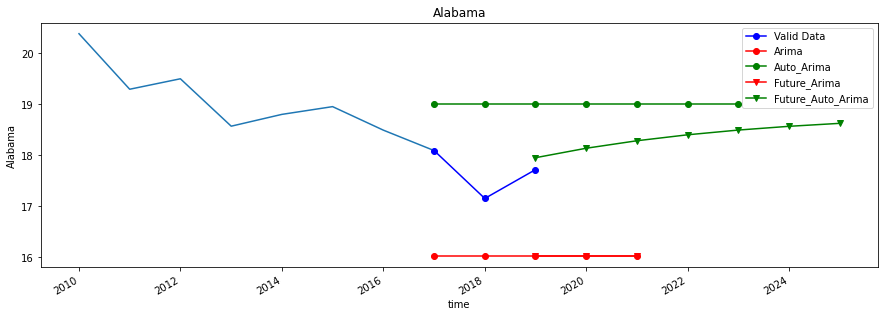

In [20]:
# Creating a states list for proof that it can work on multiple states
states = ['Georgia', 'Alabama']

for s in states:
    # Training data
    train_data = df_train[['time', s]]
    
    # Valid data
    valid_data = df_val[['time', s]]
    
    #all data
    all_data = df_rev[['time', s]]
    
    #Set time column to index
    train_data.set_index('time', inplace = True)
    valid_data.set_index('time', inplace = True)
    valid_data.columns = ['Valid Data'] ##To see it on the graph
    all_data.set_index('time', inplace = True)
    
    # Set valid index for 5 years
    index_7_years = pd.date_range(train_data.index[-1], freq = 'AS', periods = 7)
    
    # Future index - 5 years
    future_7_years = pd.date_range(valid_data.index[-1], freq = 'AS', periods = 7)
    
    # Reset the forecasts from the previous state, otherwise if a state fails to work in the Arima model, the forecast from the previous state
    #is going to be passed in.
    
    # Drop all tables:
    try:
        del t_fcast1
        del t_fcast2
        #del t_fcast3
    
        del f_fcast1
        del f_fcast2
        #del f_fcast3
    except:
        print('')
    
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
    except:
        print('')

# Arima Model

# Arima Validation Phase 
    try:
        model_arima = ARIMA(train_data, order=(1,1,1),freq='AS-JAN')
        model_arima_fit = model_arima.fit()

        t_fcast1 = model_arima_fit.forecast(7)[0]

        t_fcast1 = pd.Series(fcast1, index=index_7_years)
        t_fcast1 = t_fcast1.rename('Arima')
    except:
        print(s, 'Arima Train Error')

#Arima Future Phase    
    try:
        model_arima = ARIMA(all_data, order=(1,1,1),freq='AS-JAN')
        model_arima_fit = model_arima.fit()

        f_fcast1 = model_arima_fit.forecast(7)[0]

        f_fcast1 = pd.Series(fcast1, index=future_7_years)
        f_fcast1 = f_fcast1.rename('Future_Arima')
    except:
        print(s, 'Arima Future Error')
        

# Auto-Arima

# Auto Arima Validation phase
    try:
        auto_arima_model = pm.auto_arima(train_data, seasonal = False, m = 0,freq = 'AS-JAN', error_action = 'ignore')

        t_fcast2 = auto_arima_model.predict(7)
        t_fcast2 = pd.Series(t_fcast2, index = index_7_years)
        t_fcast2 = t_fcast2.rename('Auto_Arima')
    except:
        print(s, 'Auto Arima Train Error')
        

#Auto Arima Future phase
    try:
        auto_arima_model = pm.auto_arima(all_data, seasonal = False, m = 0,freq = 'AS-JAN')

        f_fcast2 = auto_arima_model.predict(7)
        f_fcast2 = pd.Series(f_fcast2, index = future_7_years)
        f_fcast2 = f_fcast2.rename('Future_Auto_Arima')
    except:
        print(s, 'Auto Arima Future Error')
    
# Plotting
fig, ax = plt.subplots(figsize = (15,5))
chart = sns.lineplot(x = 'time', y = s, data = train_data)
chart.set_title(s)
valid_data.plot(ax = ax, color = 'blue', marker = 'o', legend = True)

# Plotting val
try:
    t_fcast1.plot(ax = ax, color = 'red', marker = 'o', legend = True)
except:
    print('')
try:
    t_fcast2.plot(ax = ax, color = 'green', marker = 'o', legend = True)
except:
    print('')
    
# Plotting future
try:
     f_fcast1.plot(ax = ax, color = 'red', marker = 'v', legend = True)
except:
    print('')
try:
    f_fcast2.plot(ax = ax, color = 'green', marker = 'v', legend = True)
except:
    print('');

<a id='agg2'></a>
### Model Aggregation 2: Arima, Auto Arima and Prophet 

In [21]:
df_train.head()

,time,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,2010-01-01,20.379104,15.021739,20.746667,19.257333,17.989655,14.126563,11.712500,12.366667,15.800000,...,12.238462,18.925263,17.921654,15.944828,13.778571,14.051880,16.066667,15.025455,13.350000,11.917391
1,2011-01-01,19.292537,14.573913,19.553333,18.981333,17.800000,14.257813,12.050000,12.000000,16.459510,...,12.096923,16.754737,17.421260,16.275862,12.864286,13.425564,15.679487,15.512727,12.484722,12.134783
2,2012-01-01,19.497412,14.694528,19.090460,19.714232,17.426683,15.542930,14.532038,13.230666,15.715312,...,12.520599,17.603121,18.745160,16.748769,13.050120,12.680996,16.127143,15.269241,13.032920,11.989623
3,2013-01-01,18.569592,13.969532,17.847161,19.430470,16.244368,14.568059,13.883338,13.030318,14.476778,...,12.342894,17.065653,18.319248,15.544147,13.359190,12.137138,14.955172,14.998278,12.649662,13.004587
4,2014-01-01,18.800626,14.249142,17.526119,19.743033,14.952682,13.914748,13.580065,13.212005,14.995769,...,12.442048,17.053937,17.593981,14.596301,13.566219,11.895906,14.601072,15.774113,12.433148,12.781083


The below code aggregates all 4 ML methods. Runs with sereval ERRORS, but it runs (for several minutes or more, based on computinging power):

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most 

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most 

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameter

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most 

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most 

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most 

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsm

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most 

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent ca

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameter

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent ca

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most 

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,2)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/iraseidman/opt/anaconda3/lib/python3.8/site-pac

/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/iraseidman/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information wa

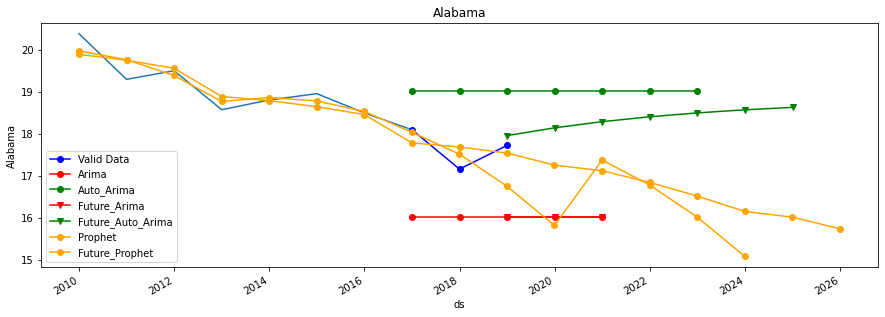

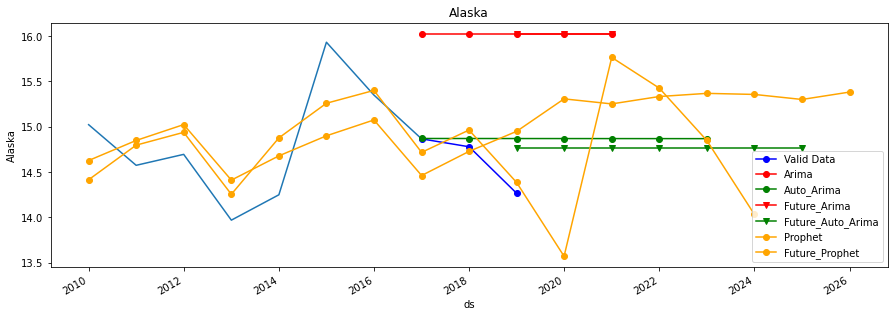

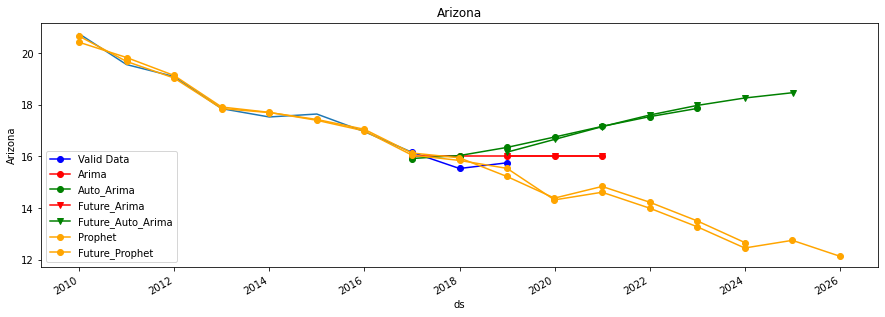

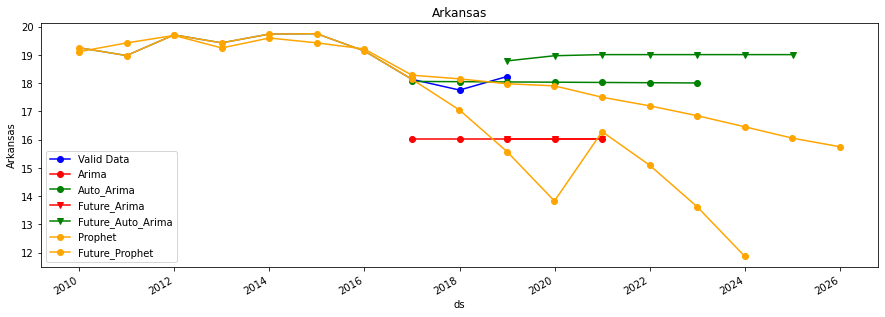

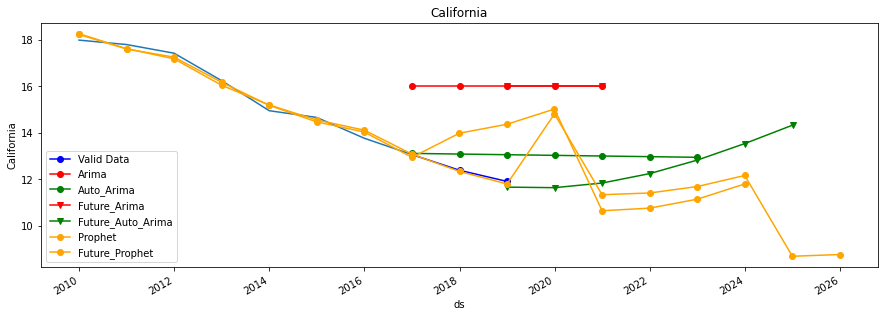

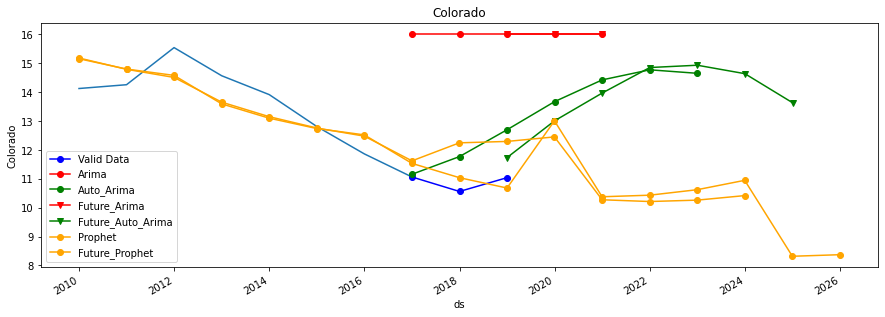

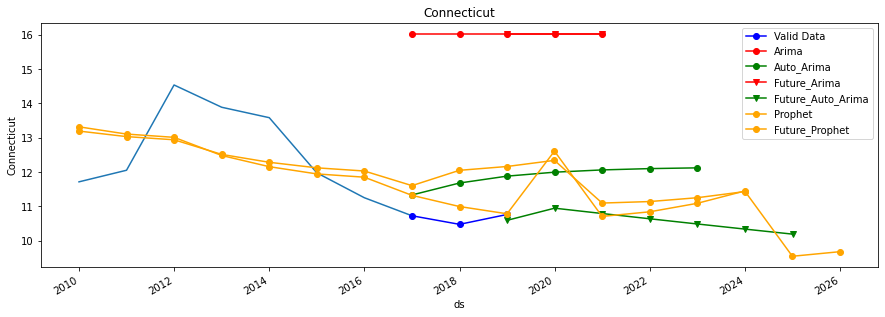

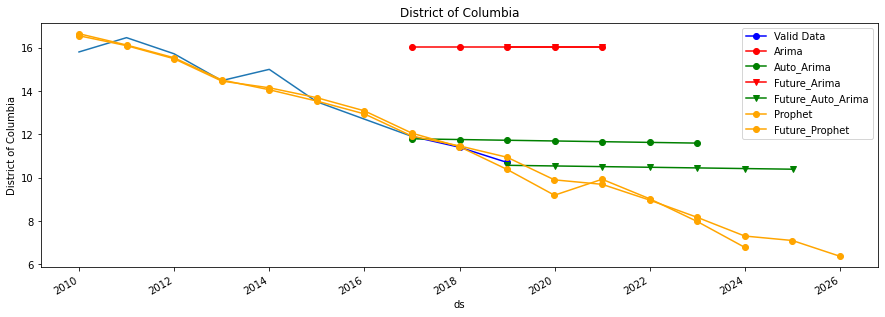

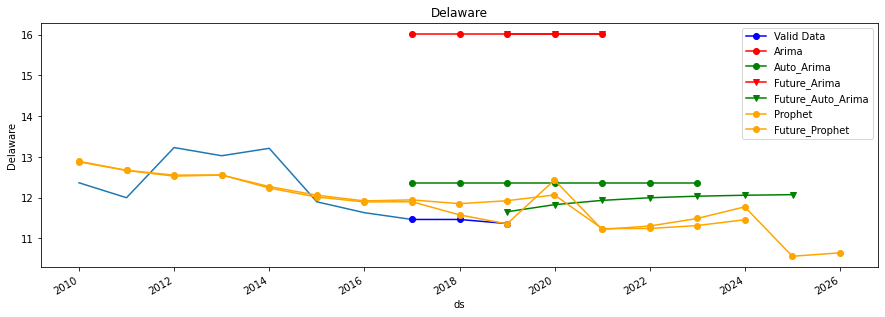

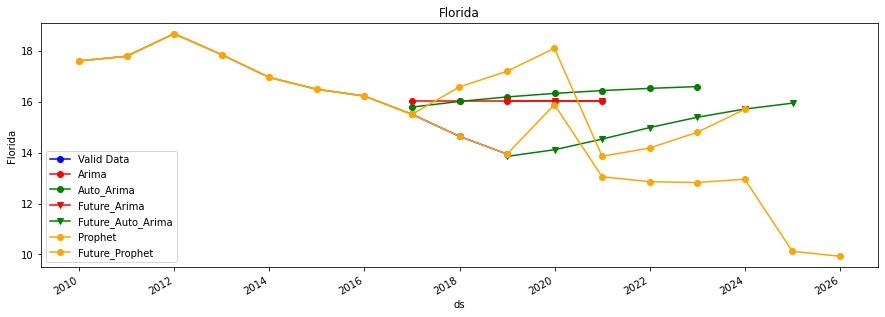

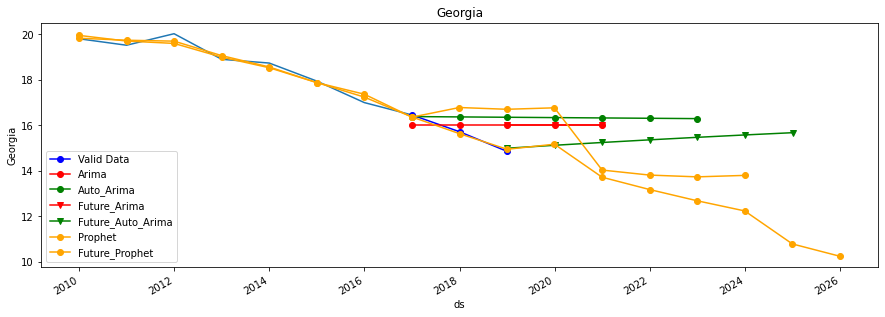

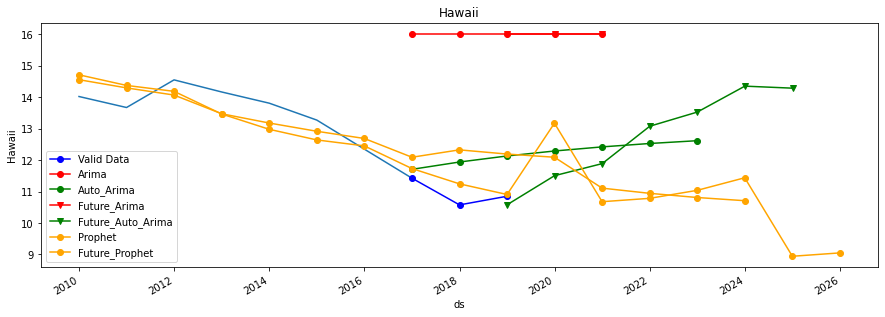

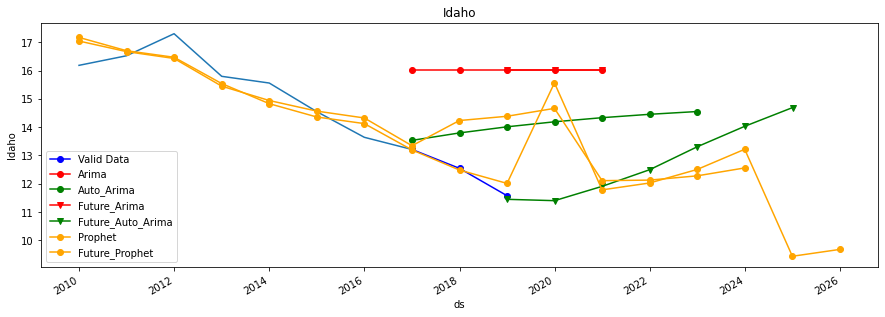

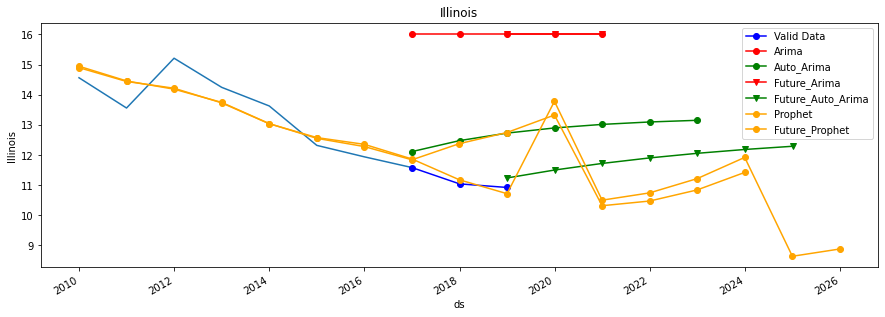

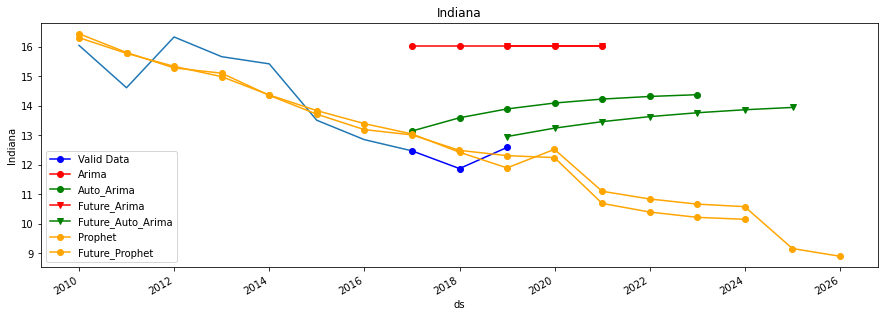

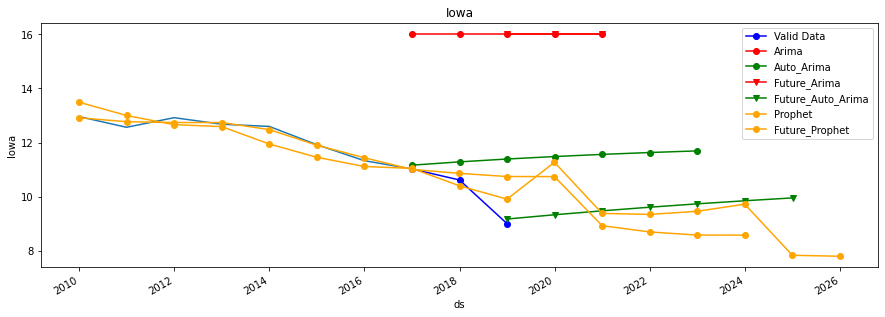

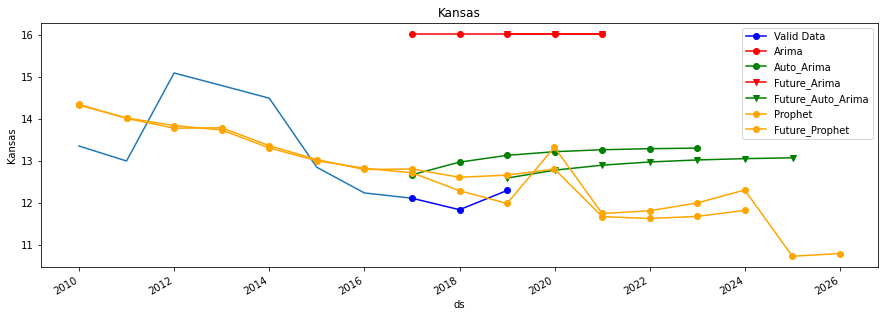

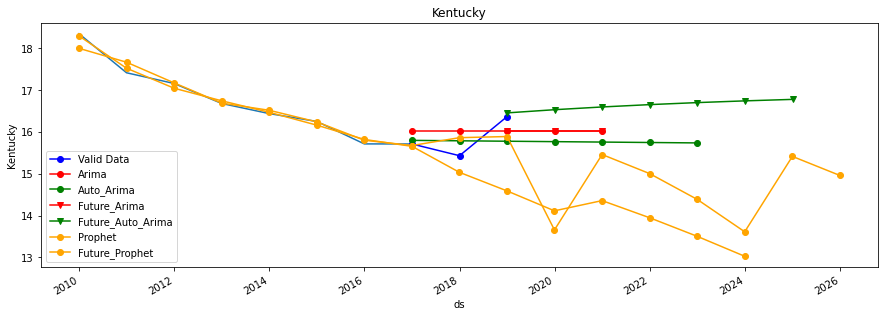

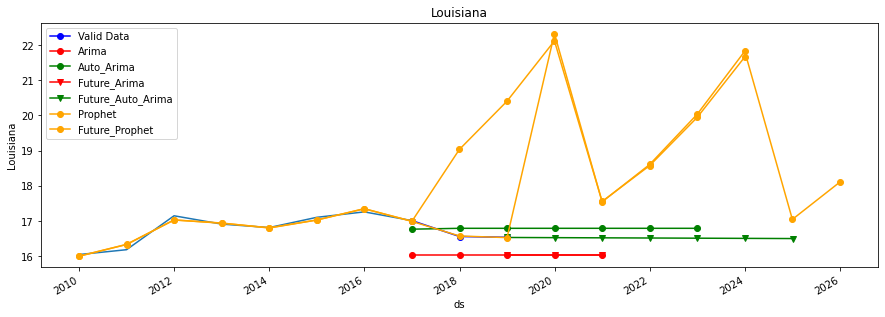

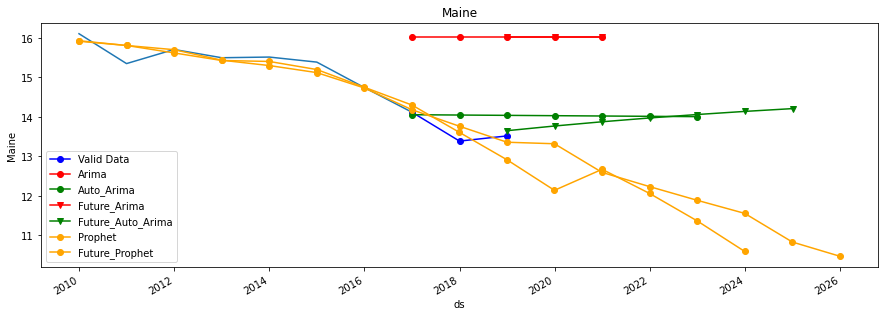

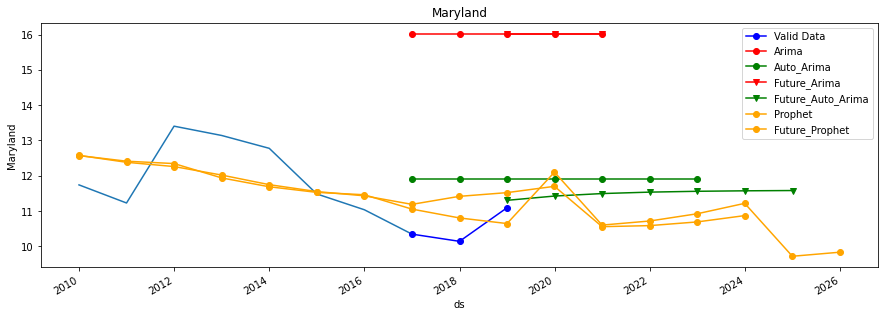

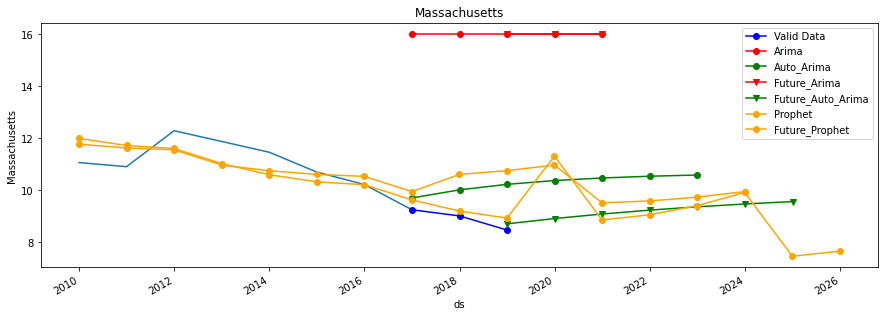

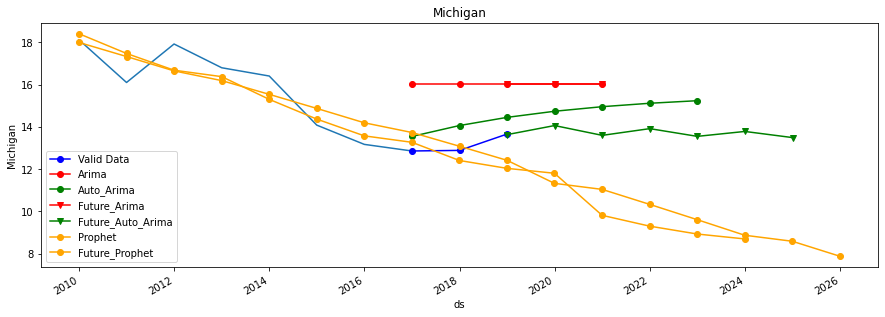

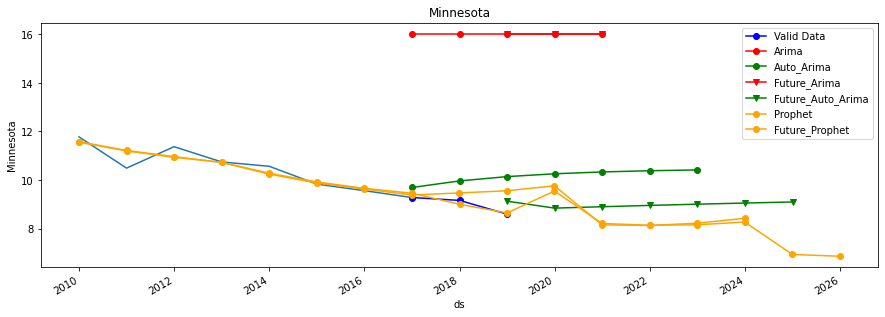

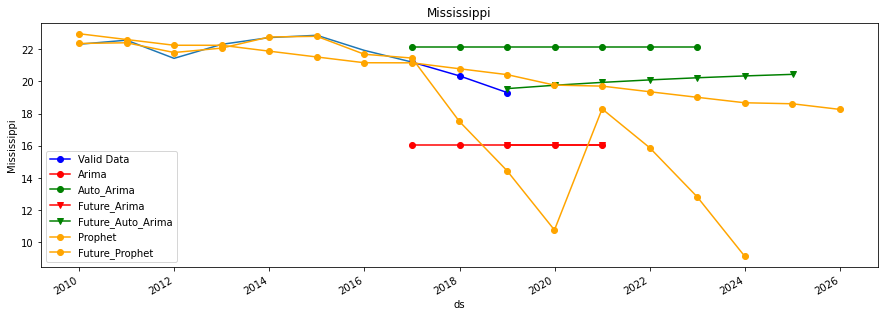

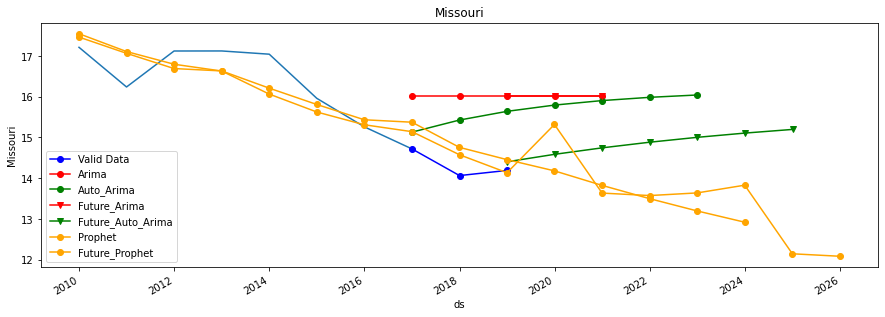

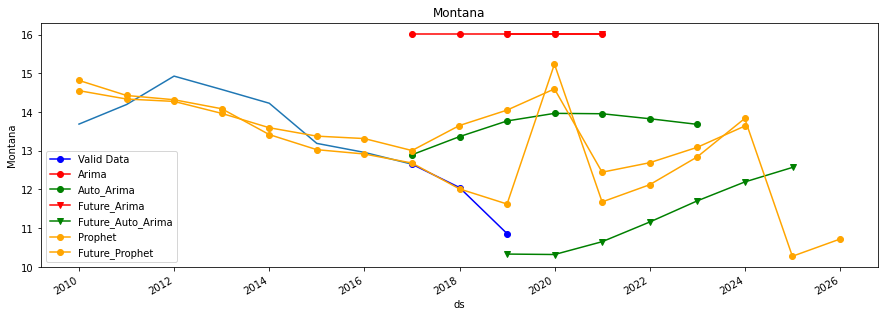

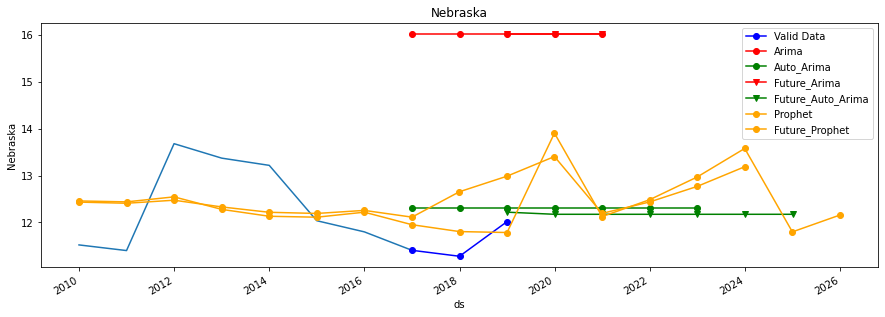

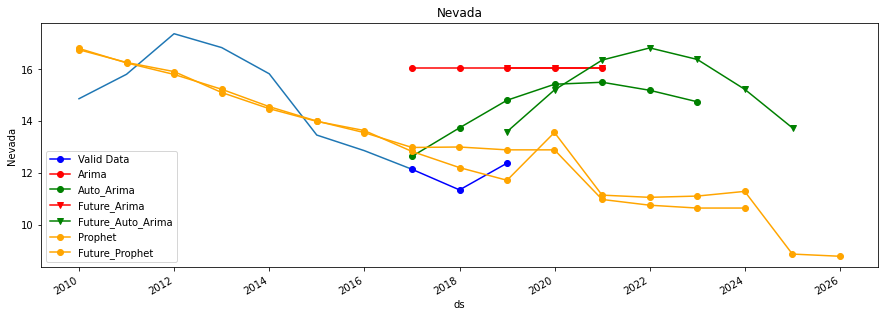

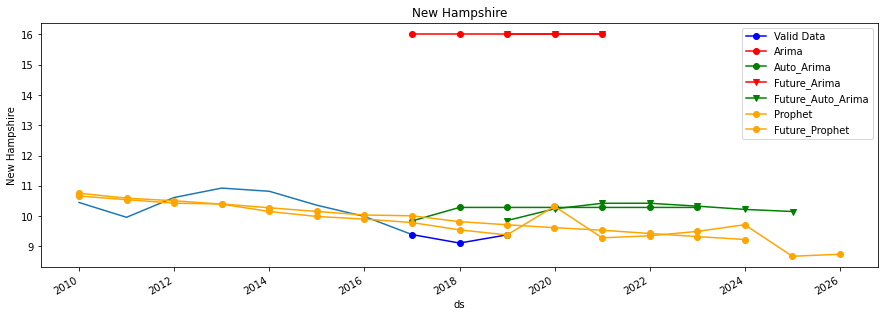

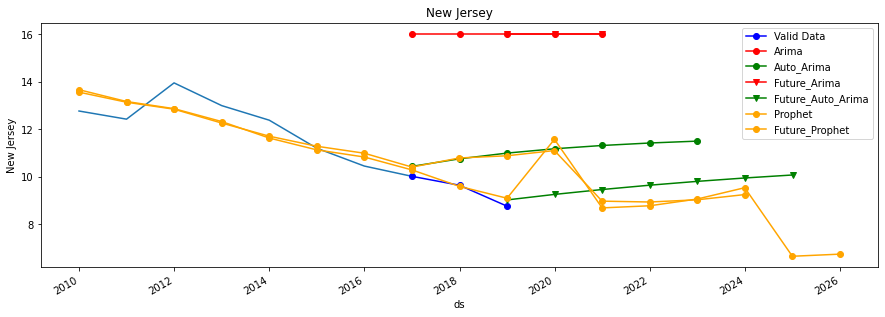

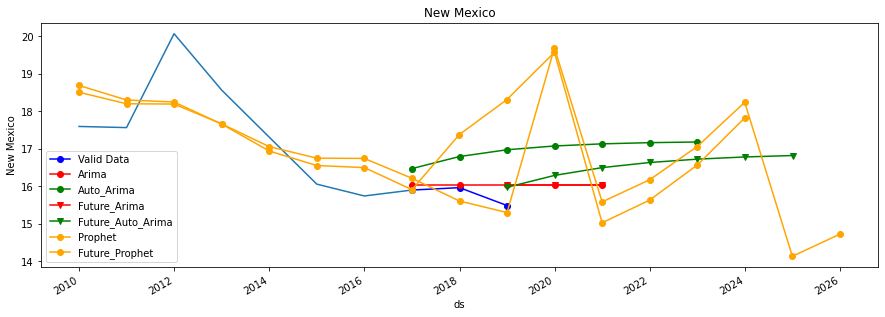

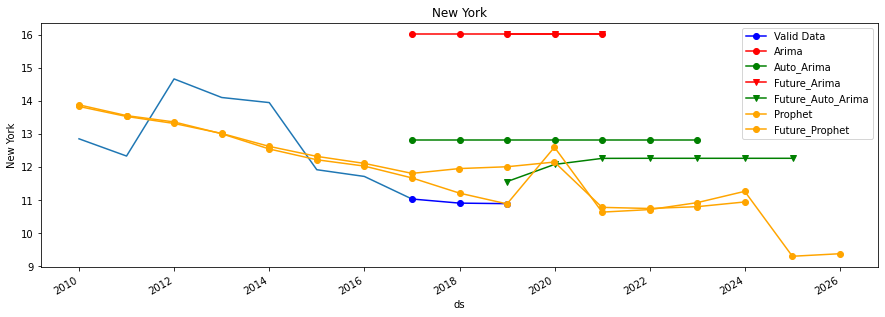

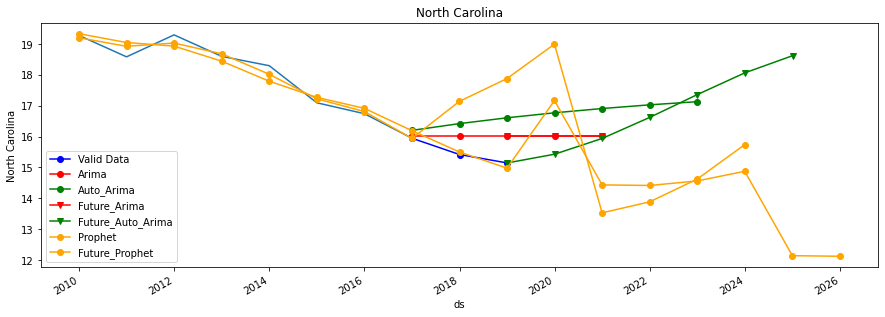

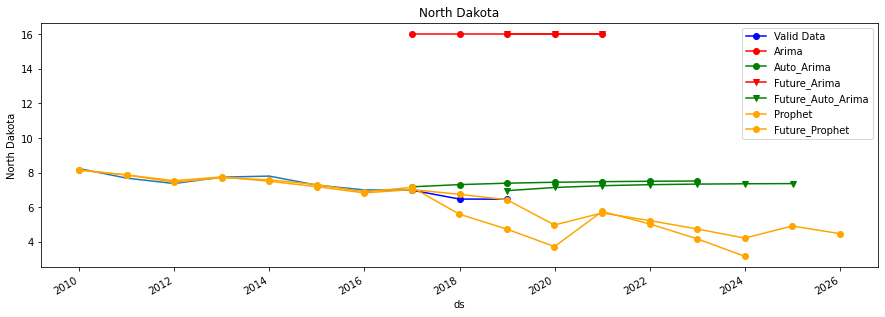

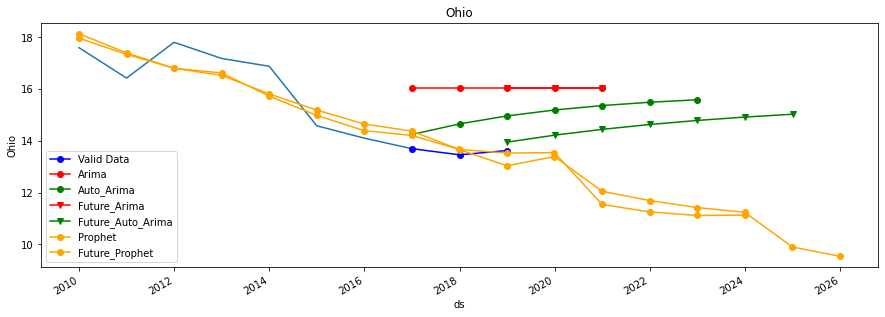

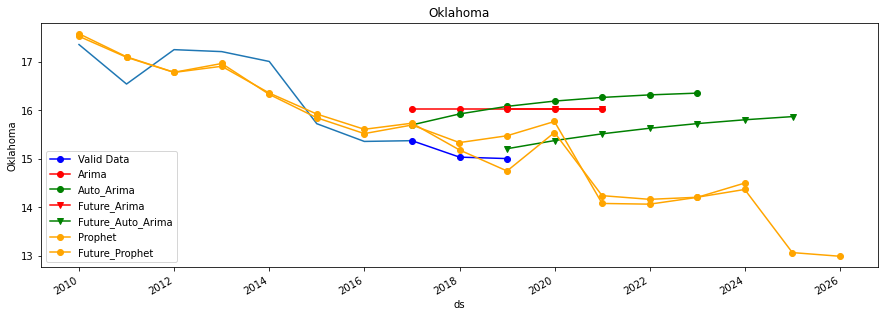

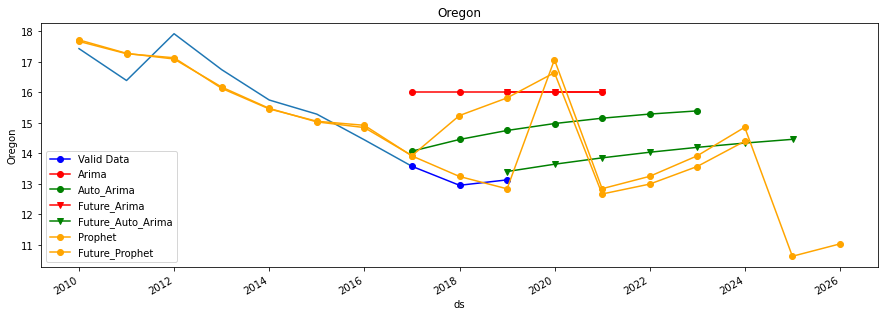

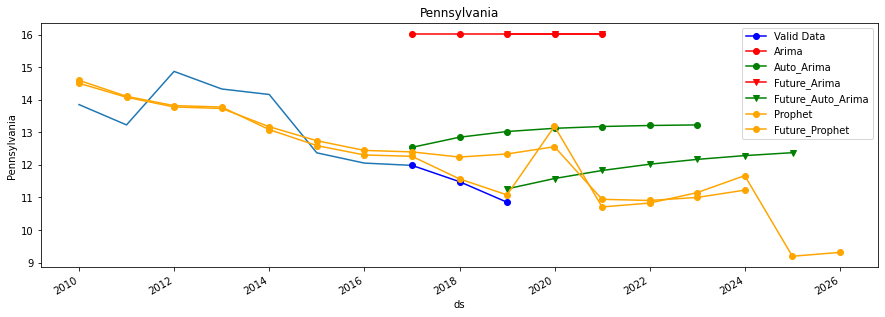

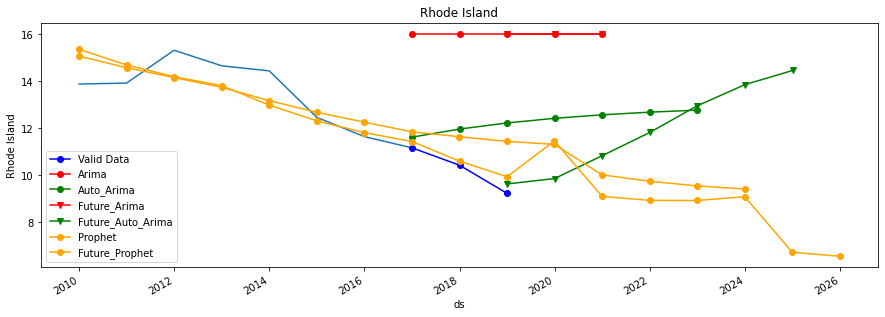

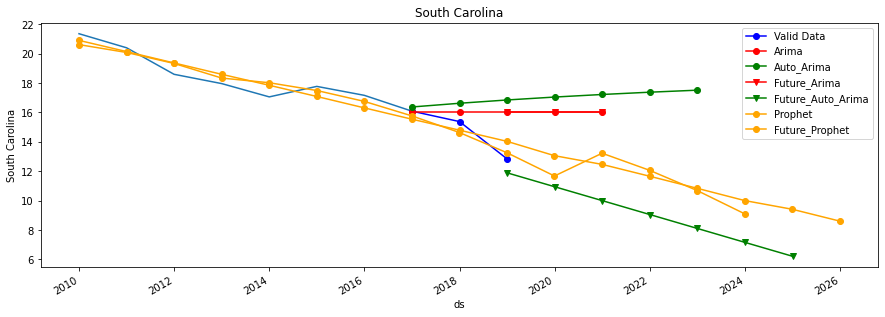

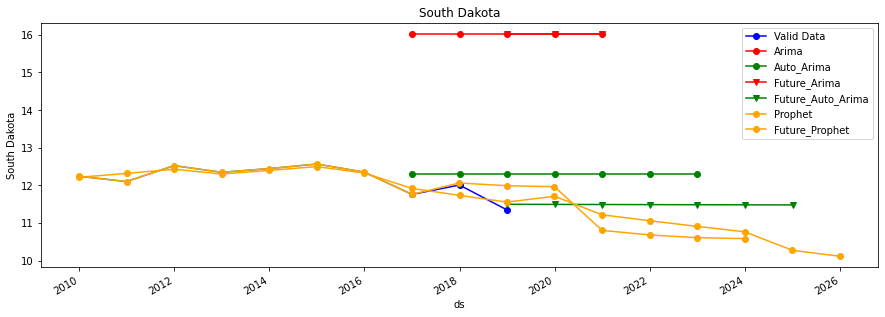

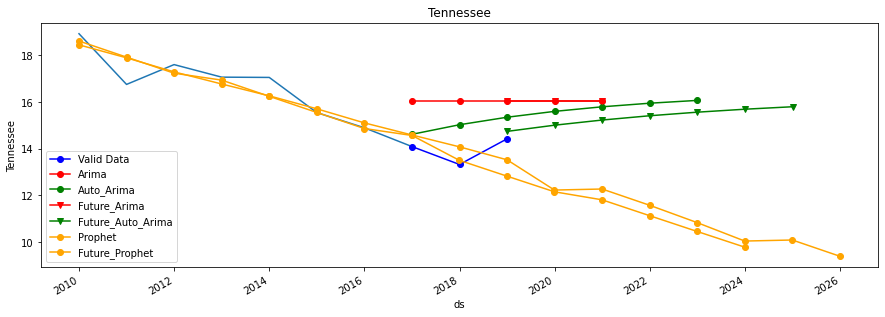

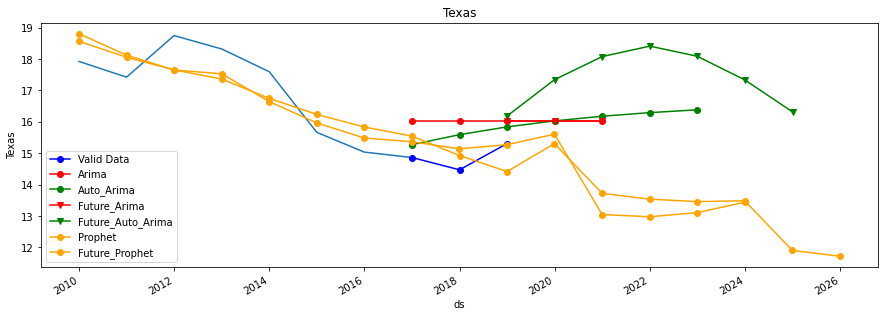

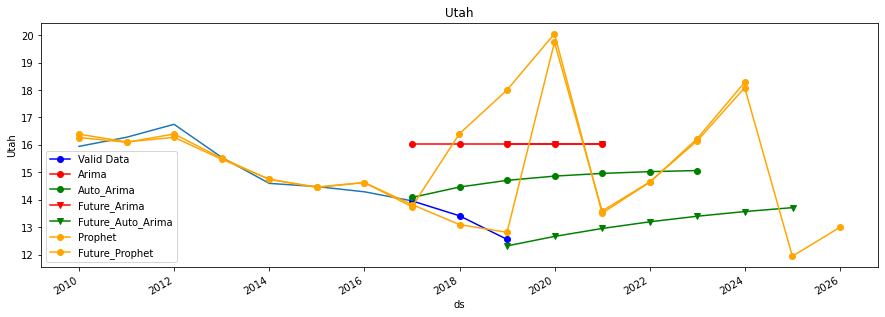

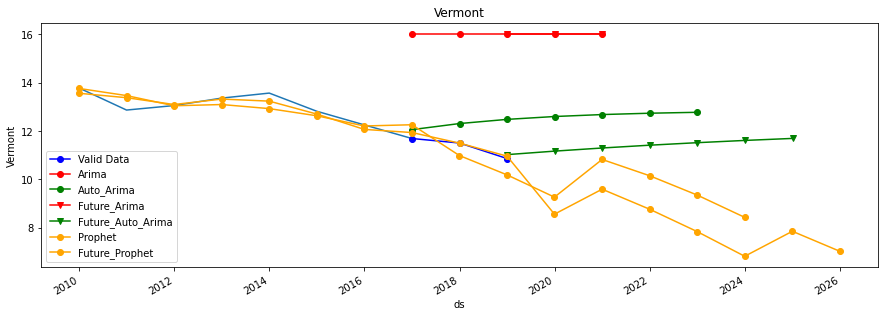

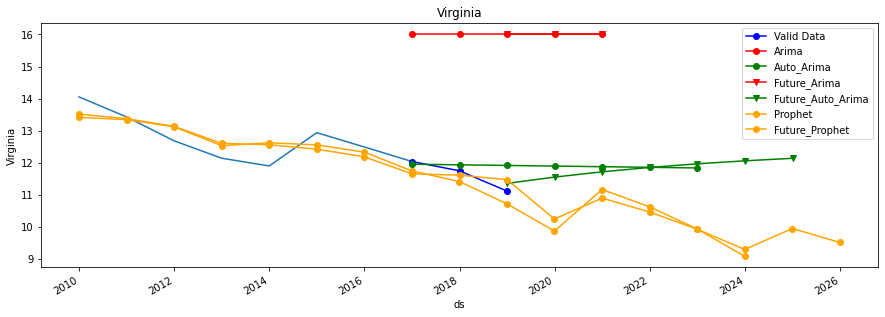

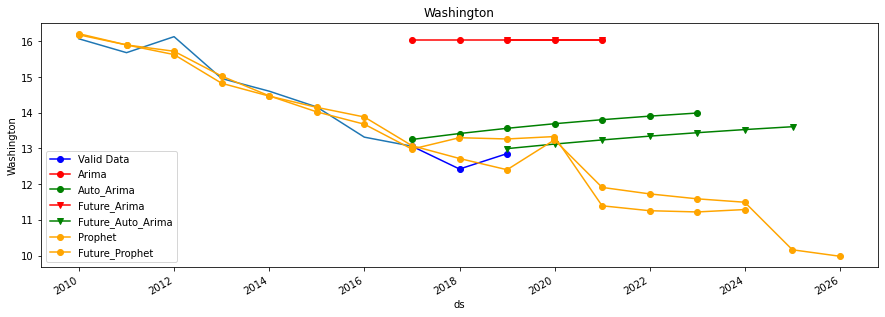

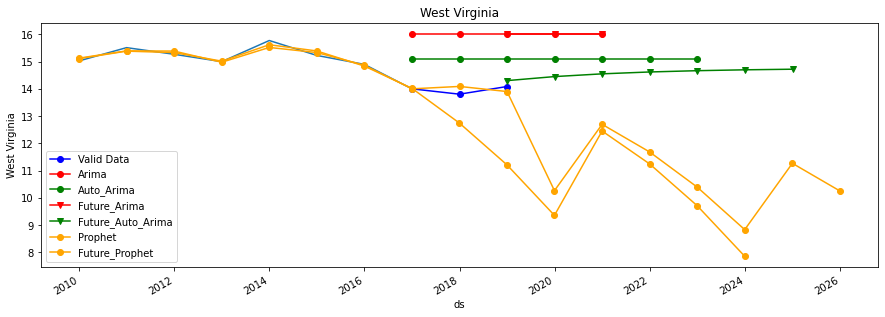

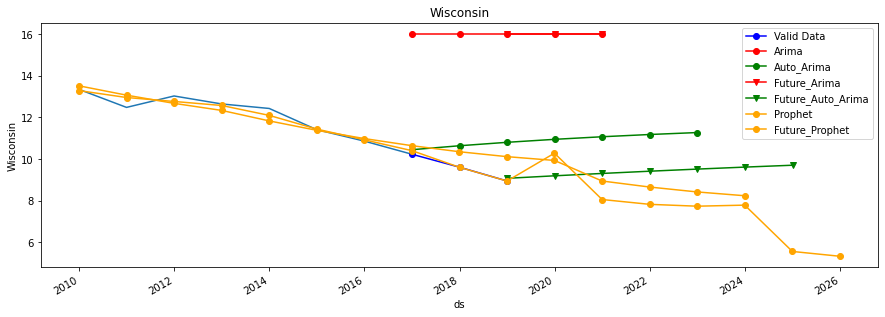

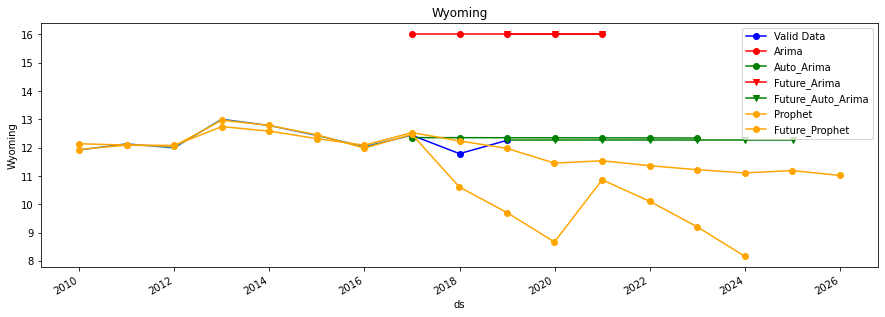

In [22]:
## Creating a full states list:

states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado',
          'Connecticut','District of Columbia', 'Delaware','Florida','Georgia','Hawaii','Idaho',
          'Illinois', 'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland',
          'Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana',
          'Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York',
          'North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania',
          'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah',
          'Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

for s in states:
    # Rraining data
    train_data = df_train[['time', s]]
    
    # Validation data
    valid_data = df_val[['time', s]]
    
    # All data
    all_data = df_rev[['time', s]]
    
    # Set time column to index
    train_data.set_index('time', inplace=True)
    valid_data.set_index('time', inplace=True)
    valid_data.columns = ['Valid Data'] ##To see it on the graph
    all_data.set_index('time', inplace=True)
    
    # Set valid index for 7 years
    index_7_years = pd.date_range(train_data.index[-1], freq = 'AS', periods = 7)
    
    # Future index - 7 years
    future_7_years = pd.date_range(valid_data.index[-1], freq = 'AS', periods = 7)
    
    # Reset the forecasts from the previous state, otherwise, if a state fails to work in the Arima model the forecast from the previous state
    #is going to be passed in
    
    # Drop all tables:
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
#         del t_fcast4
    
        del f_fcast1
        del f_fcast2
        del f_fcast3
#         del f_fcast4
    except:
        print('')
    
    try:
        del t_fcast1
        del t_fcast2
        del t_fcast3
    except:
        print('')

##################################################################################################################
################################################ Arima #########################################################
##################################################################################################################


############################################# Arima Validation Phase ###################################################

    try:
        model_arima = ARIMA(train_data, order=(1, 1, 1),freq = 'AS-JAN');
        model_arima_fit = model_arima.fit();

        t_fcast1 = model_arima_fit.forecast(7)[0]

        t_fcast1 = pd.Series(fcast1, index = index_7_years)
        t_fcast1 = t_fcast1.rename('Arima')
    except:
        print(s, 'Arima Train Error')
          

################################################  Arima Future Phase ###################################################

            
    try:
        model_arima = ARIMA(all_data, order = (1, 1, 1), freq = 'AS-JAN');
        model_arima_fit = model_arima.fit();

        f_fcast1 = model_arima_fit.forecast(7)[0]

        f_fcast1 = pd.Series(fcast1, index = future_7_years)
        f_fcast1 = f_fcast1.rename('Future_Arima')
    except:
        print(s, 'Arima Future Error')
        

##################################################################################################################
################################################ Auto Arima ######################################################
##################################################################################################################


################################################  Auto Arima Validation Phase ###################################################

    try:
        auto_arima_model = pm.auto_arima(train_data, seasonal = False, m = 0)

        t_fcast2 = auto_arima_model.predict(7)
        t_fcast2 = pd.Series(t_fcast2, index = index_7_years)
        t_fcast2 = t_fcast2.rename('Auto_Arima')
    except:
        print(s, 'Auto Arima Train Error')
        

################################################  Auto Arima Future Phase ###################################################
   
    try:
        auto_arima_model = pm.auto_arima(all_data, seasonal = False, m = 0)

        f_fcast2 = auto_arima_model.predict(7);
        f_fcast2 = pd.Series(f_fcast2, index = future_7_years)
        f_fcast2 = f_fcast2.rename('Future_Auto_Arima')
    except:
        print(s, 'Auto Arima Future Error')
    
##################################################################################################################
################################################ Prophet #########################################################
##################################################################################################################

    #Expected column names Train
    train_data3 = df_train[['time', s]].copy()
    train_data3.columns = ['ds', 'y']
    train_data3['ds'] = pd.to_datetime(train_data3['ds'])

    #Expected column names Tall
    all_data3 = df_rev[['time', s]].copy()
    all_data3.columns = ['ds', 'y']
    all_data3['ds'] = pd.to_datetime(all_data3['ds'])
    
################################################  Prophet Validation Phase ###################################################
        
    model_p = Prophet(daily_seasonality=False, weekly_seasonality = False);
    model_p.fit(train_data3);

    ##make validation index 
    val = model_p.make_future_dataframe(7, freq = 'Y')
    
    #make predictions
    t_fcast3 = model_p.predict(val)
    t_fcast3 = pd.Series(t_fcast3['yhat'].values, name = 'Prophet', index = t_fcast3['ds'])

################################################  Prophet Future Phase #######################################################
    
    model_pf = Prophet(daily_seasonality = False, weekly_seasonality = False);
    model_pf.fit(all_data3);

    ##make validation index 
    future = model_pf.make_future_dataframe(7, freq = 'Y')
    
    #make predictions
    f_fcast3 = model_pf.predict(future)
    f_fcast3 = pd.Series(f_fcast3['yhat'].values, name = 'Future_Prophet', index = f_fcast3['ds'])


                                                            
##################################################################################################################
################################################ Plotting ######################################################
##################################################################################################################

    fig, ax = plt.subplots(figsize = (15, 5))
    chart = sns.lineplot(x = 'time', y = s, data = train_data)
    chart.set_title(s)
    valid_data.plot(ax = ax, color = 'blue', marker = 'o', legend = True);
# Plotting val
    try:
        t_fcast1.plot(ax = ax, color = 'red', marker = 'o', legend = True);
    except:
        print('')
    try:
        t_fcast2.plot(ax = ax, color = 'green', marker = 'o', legend = True);
    except:
        print('')

# Plotting future
    try:
        f_fcast1.plot(ax = ax, color = 'red', marker = 'v', legend = True);
    except:
        print('')
    try:
        f_fcast2.plot(ax = ax, color = 'green', marker = 'v', legend = True);
    except:
        print('')
    
    t_fcast3.plot(ax = ax, color = 'orange', marker = 'o', legend = True);
    f_fcast3.plot(ax = ax, color = 'orange', marker = 'o', legend = True);
#     t_fcast4.plot(ax = ax, color = 'black', marker = 'o', legend = True)
#     f_fcast4.plot(ax = ax, color = 'black', marker = 'o', legend = True)

##################################################################################################################
################################################ Saving into DataFrames ##########################################
##################################################################################################################

################################################  DF Arima #######################################################

    try:
        # Creating df for forecast1
        t_fcast1 = t_fcast1.reset_index()
        t_fcast1.columns = ['Year', 'Arima ForecastValue Validation']
        
        f_fcast1 = f_fcast1.reset_index()
        f_fcast1.columns = ['Year', 'Arima ForecastValue Future']
        
        # Extra Columns
        t_fcast1['Arima ForecastValue Future'] = np.nan
        f_fcast1['Arima ForecastValue Validation'] = np.nan
        
        # Reordering
        t_fcast1 = t_fcast1[['Year', 'Arima ForecastValue Future', 'Arima ForecastValue Validation']]
        
        # Joining them togther
        df_fcast1 = pd.concat([t_fcast1, f_fcast1], axis = 0)
        df_fcast1['State'] = s
        df_fcast1['ML Method'] = 'Arima'
#         df_fcast1['Arima MSE'] = t_fcast1_mse
    
    except:
        df_fcast1 = pd.DataFrame({'Year': [np.nan], 'Arima ForecastValue Future': [np.nan], 'Arima ForecastValue Validation': [np.nan], 'State': [s], 'ML Method': ['Arima']})

################################################  DF Auto Arima #######################################################
     
    try:
        #Creating df for forecast2
        t_fcast2 = t_fcast2.reset_index()
        t_fcast2.columns = ['Year', 'Auto Arima ForecastValue Validation']
        
        f_fcast2 = f_fcast2.reset_index()
        f_fcast2.columns = ['Year', 'Auto Arima ForecastValue Future']
        
        #Extra Columns
        t_fcast2['Auto Arima ForecastValue Future'] = np.nan
        f_fcast2['Auto Arima ForecastValue Validation'] = np.nan
        
        #Reordering
        t_fcast2 = t_fcast2[['Year', 'Auto Arima ForecastValue Future', 'Auto Arima ForecastValue Validation']]
        
        # Joining them togther
        df_fcast2 = pd.concat([t_fcast2, f_fcast2], axis = 0)
        df_fcast2['State'] = s
        df_fcast2['ML Method'] = 'Auto Arima'
#         df_fcast2['Auto Arima MSE'] = t_fcast2_mse
    
    except:
        df_fcast2 = pd.DataFrame({'Year': [np.nan], 'Auto Arima ForecastValue Future': [np.nan], 'Auto Arima ForecastValue Validation': [np.nan], 'State': [s], 'ML Method': ['Auto Arima']})

################################################  DF Prophet #######################################################
     
    try:
        # Creating df for forecast3
        t_fcast3 = t_fcast3.reset_index()
        t_fcast3.columns = ['Year', 'Prophet ForecastValue Validation']
    
        f_fcast3 = f_fcast3.reset_index()
        f_fcast3.columns = ['Year', 'Prophet ForecastValue Future']
        
        # Extra Columns
        t_fcast3['Prophet ForecastValue Future'] = np.nan
        f_fcast3['Prophet ForecastValue Validation'] = np.nan
        
        # Reordering
        t_fcast3 = t_fcast3[['Year', 'Prophet ForecastValue Future', 'Prophet ForecastValue Validation']]
        
        # Joining them togther
        df_fcast3 = pd.concat([t_fcast3, f_fcast3], axis = 0)
        df_fcast3['State'] = s
        df_fcast3['ML Method'] = 'Prophet'
#         df_fcast3['Prophet MSE'] = t_fcast3_mse

    except:
        df_fcast2 = pd.DataFrame({'Year': [np.nan], 'Prophet ForecastValue Future': [np.nan], 'Prophet ForecastValue Validation': [np.nan], 'State': [s], 'ML Method': ['Prophet']})
        
################################################ Aggregating and Joining #######################################################

#     df_fcast1 = df_fcast1.groupby(['Year', 'State', 'ML Method'], as_index = False).agg({'Arima ForecastValue Future': 'sum', 'Arima ForecastValue Validation': 'sum'})
#     df_fcast2 = df_fcast2.groupby(['Year', 'State', 'ML Method'], as_index = False).agg({'Auto Arima ForecastValue Future': 'sum', 'Auto Arima ForecastValue Validation': 'sum'})
    df_fcast3 = df_fcast3.groupby(['Year', 'State', 'ML Method'], as_index = False).agg({'Prophet ForecastValue Future': 'sum', 'Prophet ForecastValue Validation': 'sum'})
        
    all_forecasts = df_fcast3.copy()
#     all_forecasts = df_fcast3.merge(df_fcast2[['Year', 'Auto Arima ForecastValue Future', 'Auto Arima ForecastValue Validation']], how ='left', on = 'Year').copy()
#     all_forecasts = pd.DataFrame(all_forecasts.merge(df_fcast1[['Year', 'Arima ForecastValue Future', 'Arima ForecastValue Validation']], how ='left', on = 'Year'))
        
        #Save predictions in df. First time this will fail and just give all_forecasts, after that will concat for each state
    try: 
        final_forecasts = pd.concat([final_forecasts, all_forecasts], ignore_index = True)
    except:
        final_forecasts = all_forecasts;

In [23]:
final_forecasts.shape

(969, 5)

In [24]:
#final_forecasts.to_csv('./data/time_series/final_v1.csv')

<a id='merge'></a>
## 4. Merging Final Forecasts with Original Data

**Formatting completed in the initial run.  Below is commented out for data preservation**

Merging the final forecasts with original data. However our original dataframe is in the wrong format, so we import a new one that has a "states" row with the historical data in the correct format.

In [25]:
# Reading in our original data in the correct format and final_forecasts (which we exported above)
df_data = pd.read_csv('./data/time_series/hor_states.csv')

final_forecasts = pd.read_csv('./data/time_series/final_v1.csv')

In [26]:
df_data.head()

,Unnamed: 0,Year,State,fi
0,1.0,1/1/2010,Alabama,20.379104
1,2.0,1/1/2011,Alabama,19.292537
2,3.0,1/1/2012,Alabama,19.497412
3,4.0,1/1/2013,Alabama,18.569592
4,5.0,1/1/2014,Alabama,18.800626


Formatting already applied, commented out to preserve data

In [27]:
# Setting consistent columns
df_data['Prophet ForecastValue Future'] = np.nan
df_data['Prophet ForecastValue Validation'] = np.nan

#adding this column to keep consistency across both before union
final_forecasts['fi'] = np.nan

In [28]:
# Converting both to datetime so types are the same for the concat
df_data['Year'] = pd.to_datetime(df_data['Year'])
final_forecasts['Year'] = pd.to_datetime(final_forecasts['Year'])

In [29]:
df_data.head(1)

,Unnamed: 0,Year,State,fi,Prophet ForecastValue Future,Prophet ForecastValue Validation
0,1.0,2010-01-01,Alabama,20.379104,NaN,NaN


In [30]:
final_forecasts.head(1)

,Unnamed: 0,Year,State,Prophet ForecastValue Future,Prophet ForecastValue Validation,fi
0,0,2010-01-01,Alabama,19.888816,19.968676,NaN


In [31]:
# Reordering for concat
final_forecasts = final_forecasts[['Unnamed: 0', 'Year', 'State', 'fi', 'Prophet ForecastValue Future', 'Prophet ForecastValue Validation']]

In [32]:
# Concatening and dropping and renaming columns 
output_df = pd.concat([df_data, final_forecasts], axis = 0)

del output_df['Unnamed: 0']

output_df.rename(columns = {'fi': 'Food Insecurity Rate'}, inplace = True)

In [33]:
# Exporting to CSV
output_df.to_csv('./data/time_series/output_df.csv')